In [1]:
from __future__ import division

from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [115]:
# Description:
#   Exercise3 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter, map_coordinates
from scipy.misc import imresize
from scipy.ndimage.filters import convolve as conv2
from scipy.ndimage.filters import convolve1d as conv1
import math

from utils import rgb2gray, imnoise, add_gaussian_noise, gaussian2, affinefit


# CS-E4850 Computer Vision Exercise Round 3
For these exercises you will need a python environment with necessary packages installed. For installation, see the README in the main page of this assignments repository.<br><br> The problems should be solved before the exercise session and solutions returned via the
MyCourses page. Upload only ONE file for the programming tasks, i.e. this notebook filled with your implementations and anything else that is asked or needed. <br> Note that (1) you are not supposed to change anything in the utils.py and (2) you should be sure that everything that that you need to implement should work with the pictures specified by the assignments of this exercise round. 

## Exercise 1 - Image denoising

In this exercise you will need to denoise the two example images using<br>
a) Gaussian filtering, <br>
b) median filtering, and <br>
c) bilateral filtering (the latter two are explained in Section 3.3.1 of Szeliski’s book).

/Users/rongmac/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


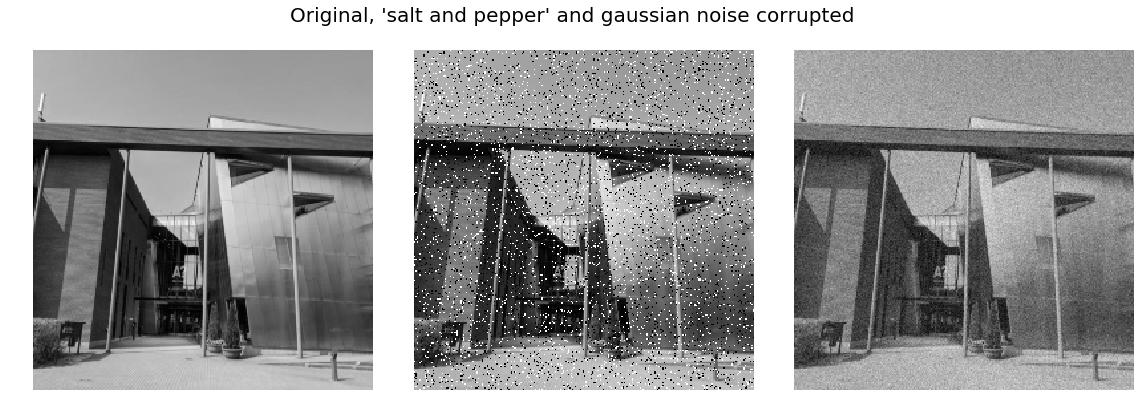

In [2]:
## Load test images.
## Note: Must be double precision in the interval [0,1].
im = rgb2gray(imread('department2.jpg')) / 255.
im = resize(im, (256, 256))

## Add noise
## "salt and pepper" noise
imns = imnoise(im, 'salt & pepper', 0.05)
## zero-mean gaussian noise
imng = im + 0.05*np.random.randn(im.shape[0],im.shape[1])

# Display original and noise corrupted images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[1].imshow(imns, cmap='gray')
ax[1].axis('off')
ax[2].imshow(imng, cmap='gray')
ax[2].axis('off')
plt.tight_layout()
plt.suptitle("Original, 'salt and pepper' and gaussian noise corrupted", fontsize=20)
plt.subplots_adjust(top=1.2)
plt.show()

## Don't worry about the possible warnings below

### a) Gaussian filtering

In [3]:
## Apply Gaussian filter of std 2.5 
sigmad = 2.5
g,_,_,_,_,_, = gaussian2(sigmad)

gflt_imns = conv2(imns, g, mode='reflect')
gflt_imng = conv2(imng, g, mode='reflect')

## Instead of directly filtering with g, make a separable implementation
## where you use horizontal and vertical 1D convolutions
## That is, replace the above two lines, you can use conv1 instead
## The result should not change.

##--your-code-starts-here--##

# calculate the 1d gaussian kernel with known sigma
def gaussian1d(sigma, N=None):
    if N is None:
        N = 2*np.maximum(4, np.ceil(6*sigma))+1
    k = (N - 1) / 2.
    x = np.arange(-k,k+1)
    g = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma ** 2))
    return g

kernel = gaussian1d(sigmad)

# step 1: apply the kernel on input image horizontally
gflt_imns_horizontal = conv1(imns, kernel, axis=1, mode='reflect')
# step 2: apply the kernel on the output of step 1 vertically -> final output 
gflt_imns = conv1(gflt_imns_horizontal, kernel, axis=0, mode='reflect')
gflt_imng_horizontal = conv1(imng, kernel, axis=1, mode='reflect')
gflt_imng = conv1(gflt_imng_horizontal, kernel, axis=0, mode='reflect')

##--your-code-ends-here--##

### b) Median filtering

In [4]:
## Apply median filtering, use neighborhood size 5x5

##--your-code-starts-here--##

medflt_imns = median_filter(imns, size=5, mode='reflect')
medflt_imng = median_filter(imng, size=5, mode='reflect')

##--your-code-ends-here--##


### c) Bilateral filtering

In [5]:
def bilateral_filter(img, wsize, sigma_d, sigma_r):
##--your-code-starts-here--##

    output = np.zeros(img.shape)
    radius = int((wsize-1)/2)
    
    # (i,j) is the coordinate of the central pixel 
    for i in range(0,img.shape[0]): 
        for j in range(0,img.shape[1]):
            total_weight = 0
            # (k,l) is the coordinate of neighbor pixels in the window
            for k in range(i-radius,i+radius+1):
                for l in range(j-radius,j+radius+1):
                    # if a neighbor pixel goes outside of the image boundry, 
                    # ignore it
                    if k<0 or l<0 or k>img.shape[0]-1 or l>img.shape[1]-1:
                        pixel=0
                    else:
                        pixel=img[k,l]
                    domain_kernel = math.exp(-((i-k)**2+(j-l)**2)/(2*sigma_d**2))
                    range_kernel = math.exp(-((img[i,j]-pixel)**2)/(2*sigma_r**2))
                    weight = domain_kernel * range_kernel 
                    total_weight += weight
                    output[i,j] += pixel * weight 
                    # when every pixel is iterated through in this window
                    if (k==i+radius) and (l==j+radius):
                        # normalize by total weight in this window
                        output[i,j] = output[i,j]/total_weight

##--your-code-ends-here--##
    return output


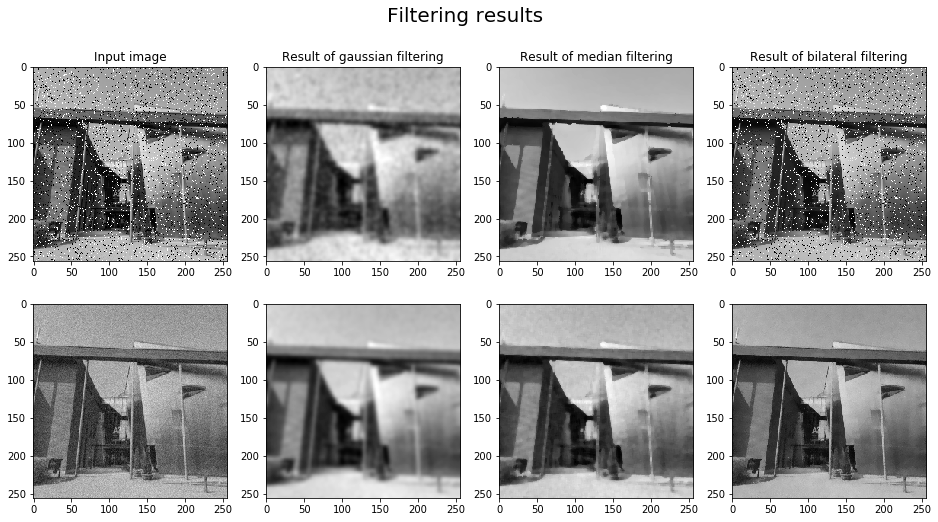

In [6]:
## Apply bilateral filter to each image and (uncomment the function calls once
## its definition is ready)

## You need to implement bilateralfilter function above.
## Use formulas (3.34)-(3.37) from Szeliski's book.
## You may freely decide in which mode ('full', 'valid', or 'same') your
## function runs (only one implementation enough), but note that with 'full' and 'same'
## you need to take care how the borders are handled (padded).

## Set bilateral filter parameters.
wsize = 11
sigma_d = 2.5
sigma_r = 0.1

bflt_imns = bilateral_filter(imns, wsize, sigma_d, sigma_r)
bflt_imng = bilateral_filter(imng, wsize, sigma_d, sigma_r)

# Display filtering results
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(imns, cmap='gray')
ax[0].set_title("Input image")
ax[1].imshow(gflt_imns, cmap='gray')
ax[1].set_title("Result of gaussian filtering")
ax[2].imshow(medflt_imns, cmap='gray')
ax[2].set_title("Result of median filtering")
ax[3].imshow(bflt_imns, cmap='gray')
ax[3].set_title("Result of bilateral filtering")
ax[4].imshow(imng, cmap='gray')
ax[5].imshow(gflt_imng, cmap='gray')
ax[6].imshow(medflt_imng, cmap='gray')
ax[7].imshow(bflt_imng, cmap='gray')
plt.suptitle("Filtering results", fontsize=20)
plt.show()

## Exercise 2 - Hybrid images
In  this  task  you  will  need  to  construct  a  hybrid  image  that  combines  facial images  of  a  wolf  and  a  man.  In  addition,  visualize  the  log  magnitudes  of  the  Fourier transforms  of  the  original  images  and  their  low-pass  and  high-pass  filtered  versions  (i.e.constituents  of  the  hybrid  image).<br><br>(Hint:  You  can  use  the  numpy.fft's  functions fft2 and fftshift as  shown  in  lecture  slides.)

In [118]:
## Load test images
man = imread('man.jpg') / 255.
wolf = imread('wolf.jpg') / 255.

# the pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461], [652, 457], [554, 823]])
wolf_eyes_chin=np.array([[851, 919], [1159, 947], [975, 1451]])
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size,1)).T
wolft = map_coordinates(wolf, (pt[1,:].reshape(man.shape), pt[0,:].reshape(man.shape)))

## Below we simply blend the aligned images using additive superimposition
additive_superimposition = man + wolft

## Next we create two different Gaussian kernels for low-pass filtering
## the two images


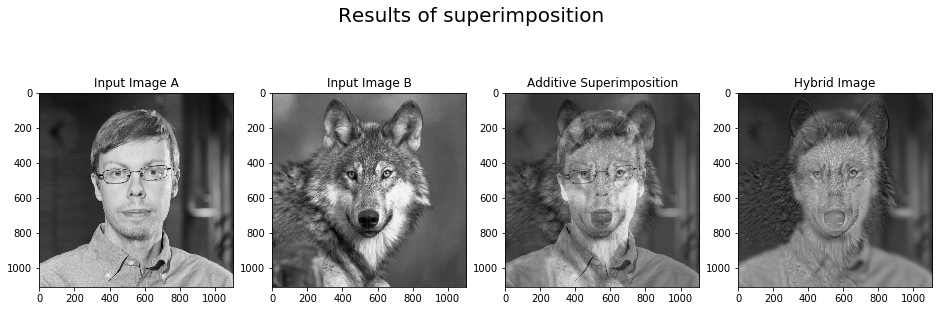

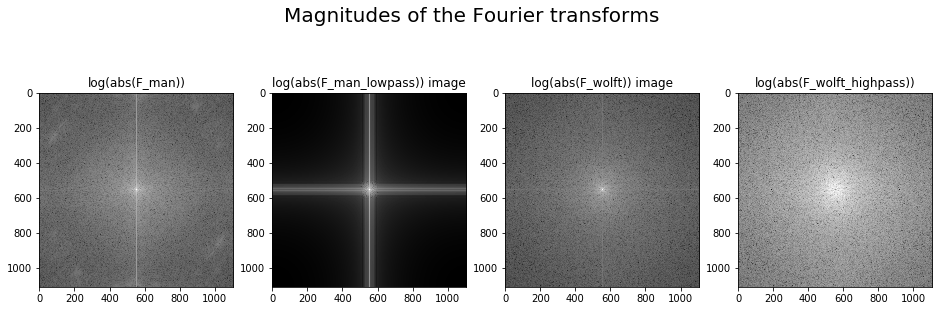

In [119]:
# naive blending by additive superimposition for illustration
superimpose = man + wolft

# low-pass filter the two images using two different Gaussian kernels
sigmaA = 16
sigmaB = 8
man_lowpass = gaussian_filter(man, sigmaA, mode='nearest')
wolft_lowpass = gaussian_filter(wolft, sigmaB, mode='nearest')
# We use gaussian_filter above in this case as it is significantly faster than the way below
#filterA,_,_,_,_,_, = gaussian2(sigmaA)
#filterB,_,_,_,_,_, = gaussian2(sigmaB)
#man_lowpass = conv2(man, filterA, mode='reflect')
#wolft_lowpass = conv2(wolft, filterB, mode='reflect')

## Your task is to create a hybrid image by combining a low-pass filtered 
## version of the human face with a high-pass filtered wolf face
 
## HINT: You get a high-pass version by subtracting the low-pass filtered version
## from the original image. Experiment also by trying different values for
## 'sigmaA' and 'sigmaB' above.
 
## Thus, your task is to replace the zero image on the following line
## with a high-pass filtered version of 'wolft'
wolft_highpass = np.zeros(man_lowpass.shape);

##--your-code-starts-here--##
sigmaA = 10
sigmaB = 10
man_lowpass = gaussian_filter(man, sigmaA, mode='nearest')
wolft_lowpass = gaussian_filter(wolft, sigmaB, mode='nearest')

wolft_highpass = wolft - wolft_lowpass
##--your-code-ends-here--##
 
## Replace also the zero image below with the correct hybrid image
hybrid_image = np.zeros(man_lowpass.shape)

##--your-code-starts-here--##
hybrid_image = man_lowpass + wolft_highpass
##--your-code-ends-here--##
 
## Notice how strongly the interpretation of the hybrid image is affected 
## by the viewing distance

## Display input images and both output images.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
plt.suptitle("Results of superimposition", fontsize=20)
ax = axes.ravel()
ax[0].imshow(man, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(wolft, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].imshow(additive_superimposition, cmap='gray')
ax[2].set_title("Additive Superimposition")
ax[3].imshow(hybrid_image, cmap='gray')
ax[3].set_title("Hybrid Image")
plt.subplots_adjust(top=1.2)
plt.show()

## Finally, visualize the log magnitudes of the Fourier
## transforms of the original images

##--your-code-starts-here--##

F_man = fftshift(fft2(man))
F_man_lowpass = fftshift(fft2(man_lowpass))
F_wolft = fftshift(fft2(wolft))
F_wolft_highpass = fftshift(fft2(wolft_highpass))

##--your-code-ends-here--##

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
plt.suptitle("Magnitudes of the Fourier transforms", fontsize=20)
ax = axes.ravel()

ax[0].imshow(np.log(np.abs(F_man)), cmap='gray')
ax[0].set_title("log(abs(F_man))")
ax[1].imshow(np.log(np.abs(F_man_lowpass)), cmap='gray')
ax[1].set_title("log(abs(F_man_lowpass)) image")
ax[2].imshow(np.log(np.abs(F_wolft)), cmap='gray')
ax[2].set_title("log(abs(F_wolft)) image")
ax[3].imshow(np.log(np.abs(F_wolft_highpass)), cmap='gray')
ax[3].set_title("log(abs(F_wolft_highpass))")
plt.subplots_adjust(top=1.2)
plt.show() 

## Exercise 3 - Image blending
Go through the final part of this notebook and see the instructions in the comments of the source code. The example  implements Laplacian pyramid blending and blends facial images of a wolf and a man. The blending process is described  in Section 3.5.5 of Szeliski’s book. You need to implement the generation procedure for Gaussian and Laplacian image pyramids and the reconstruction procedure for reconstructing an image from its Laplacian pyramid.

(Hint: You can use two 1D convolutions with the binomial filter kernel g = [1 4 6 4 1]/16
to implement the low-pass filter before downsampling. Interpolation in the reconstruction
procedure can be performed by adding zeros between the rows and columns of the lower
resolution image and then filtering horizontally and
vertically with the kernel 2g as mentioned in Figure 3.33 of Szeliski’s book.)

In [120]:
## Implement missing functions: 
## generateLaplacianPyramid and reconstLaplacianPyramid
 
## Notice that in this implementation the first level of a Gaussian pyramid 
## is the original image, and the last level of a Laplacian pyramid is the
## same as the corresponding level in the Gaussian pyramid.

man = imread('man_color.jpg') / 255.
man = resize(man, (int(man.shape[0] / 2), int(man.shape[1] / 2)))

wolf = imread('wolf_color.jpg') / 255.
wolf = resize(wolf, (int(wolf.shape[0] / 2), int(wolf.shape[1] / 2)))

# the pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461], [652, 457], [554, 823]])
wolf_eyes_chin=np.array([[851, 919], [1159, 947], [975, 1451]])
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size, 1)).T

wolft = np.zeros(man.shape)

for ch in range(3):
    wolft[:,:,ch] = map_coordinates(wolf[:,:,ch], (pt[1, :].reshape(man.shape[:2]),
                               pt[0, :].reshape(man.shape[:2])))


## Manually defined binary mask with an elliptical shape is constructed
## as well as its complement
x0=553.
y0=680.
a=160. 
b=190.
pixmask = (((xv-x0) / a) ** 2 + ((yv-y0) / b) ** 2) < 1

maskb = np.zeros(man.shape)
maskbw = np.zeros(man.shape[:2])
maskbw[pixmask] = 1.0
for c in range(3):
     maskb[:, :, c] = maskbw
maska = 1.0 - maskb

imga = resize(man, (1024,1024))
imgb = resize(wolft, (1024, 1024))
maska = resize(maska, (1024, 1024))
maskb = resize(maskb, (1024, 1024))            

/Users/rongmac/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [121]:
def generateLaplacianPyramid(im, ptype, levels):
    ##--your-code-starts-here--##
    
    def reduce(image):
        kernel = [1/16,4/16,6/16,4/16,1/16] 
        half_size = int(image.shape[0]/2)
        canvas = np.zeros((half_size,half_size,3))
        blur_0 = conv1(image, kernel, axis=0, mode='reflect')
        blur = conv1(blur_0, kernel, axis=1, mode='reflect')
        # take pixel form every other row/column
        downsample = blur[::2,::2]
        return downsample
    
    def expand(image):
        kernel = [1/8,4/8,6/8,4/8,1/8]
        double_size = int(image.shape[0]*2)
        upsample = np.zeros((double_size,double_size,3))
        upsample[::2,::2] = image
        blur_0 = conv1(upsample, kernel, axis=0, mode='reflect')
        blur = conv1(blur_0, kernel, axis=1, mode='reflect')
        return blur
    
    # gaussian pyramid
    gaussianpyramid = [im]
    p = im
    for i in range(levels-1):
        p = reduce(p)
        gaussianpyramid.append(p)
    
    # laplacian pyramid 
    laplacianpyramid = []
    for i in range(levels-1):
        g0 = gaussianpyramid[i]
        g1_expand = expand(gaussianpyramid[i+1])
        # reshape g1_expand to the same size as g
        l1 = g0 - g1_expand[:g0.shape[0],:g0.shape[1]]
        laplacianpyramid.append(l1)
    # include the top image of the gaussian pyramid as the last item
    laplacianpyramid.append(gaussianpyramid[-1])

    ##--your-code-ends-here--## 
    if ptype == 'laplacian':
        return laplacianpyramid
    elif ptype == 'gaussian':
        return gaussianpyramid
    else:
        raise ValueError('Unknown pyramid type: ' + str(ptype))

In [122]:
def reconstLaplacianPyramid(lpyramid):
    ##--your-code-starts-here--## 
    
    def expand(image):
        kernel = [1/8,4/8,6/8,4/8,1/8]
        double_size = int(image.shape[0]*2)
        upsample = np.zeros((double_size,double_size,3))
        upsample[::2,::2] = image
        blur_0 = conv1(upsample, kernel, axis=0, mode='reflect')
        blur = conv1(blur_0, kernel, axis=1, mode='reflect')
        return blur
    
    last_item = len(lpyramid)-1
    im = lpyramid[last_item]
    for i in range(1,len(lpyramid)):
        laplacian = lpyramid[last_item-i]
        im_expand = expand(im)
        reconstruct = im_expand[:laplacian.shape[0],:laplacian.shape[1]] + laplacian
        im = reconstruct
        
    ##--your-code-ends-here--## 
    return im

Reconstruction error: 3.3306690738754696e-16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


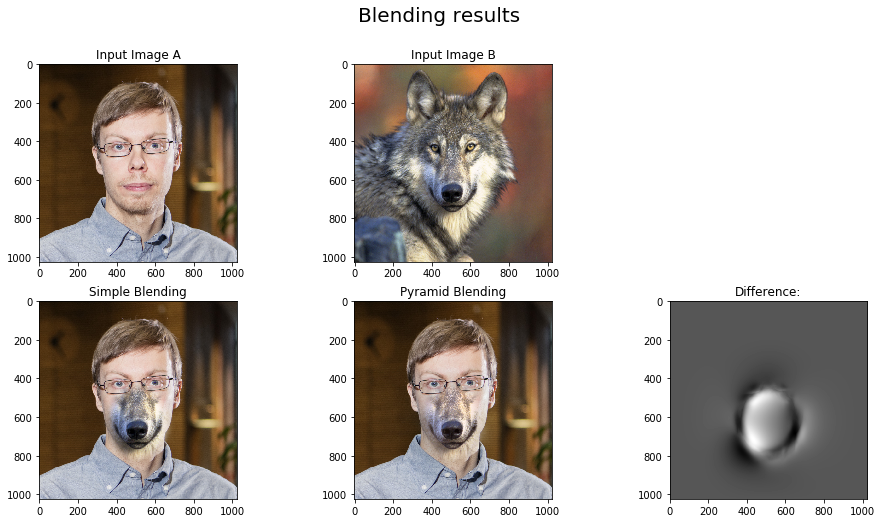

In [123]:
level = 8
 
## Make Laplacian image pyramids with 8 levels.
## Output is cell array (i.e. lpimga{i} is the Laplacian image at level i).
## The image at the final level is the base level image from the
## corresponding Gaussian pyramid.
## In the version below the second input is either 'laplacian' or 'gaussian',
## and it defines whether to output Laplacian or Gaussian pyramid.
## After you have implemented the functions above you can uncomment the lines below
## to finally plot the lacking figures ('Pyramid Blending' and 'Difference')
lpimga = generateLaplacianPyramid(imga,'laplacian',level)
lpimgb = generateLaplacianPyramid(imgb,'laplacian',level)

## Just check that your pyramid and reconstruction both work
ima = reconstLaplacianPyramid(lpimga)
max_reconstruction_error = np.amax(np.abs(imga.flatten() - ima.flatten()))
print("Reconstruction error: {}".format(max_reconstruction_error))

## Make Gaussian image pyramids of the mask images, maska and maskb
gpmaska = generateLaplacianPyramid(maska,'gaussian',level)
gpmaskb = generateLaplacianPyramid(maskb,'gaussian',level)

# Make smooth masks in a simple manner for comparison
smaska = gaussian_filter(maska, 20)
smaskb = gaussian_filter(maskb, 20)

## In practice, you can also use the Gaussian pyramids of smoothed masks. 
## In this case, the blendings (simple & pyramid) will appear more similar.
gpsmaska = generateLaplacianPyramid(smaska,'gaussian',level)
gpsmaskb = generateLaplacianPyramid(smaskb,'gaussian',level)

limgo = {} # the blended pyramid
for p in range(level):
    # Blend the Laplacian images at each level
    # (You can use either one of the two rows below.)
#    limgo[p] = (lpimga[p]*gpmaska[p] + lpimgb[p]*gpmaskb[p])/(gpmaska[p]+gpmaskb[p])
    limgo[p] = (lpimga[p]*gpsmaska[p] + lpimgb[p]*gpsmaskb[p])/(gpsmaska[p]+gpsmaskb[p])

## Reconstruct the blended image from its Laplacian pyramid  
imgo = reconstLaplacianPyramid(limgo);
 
## Simple blending with smooth masks
imgo1 = smaska*imga + smaskb*imgb

## Display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
plt.suptitle("Blending results", fontsize=20)
ax = axes.ravel()

ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(imgb, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].set_visible(False)
ax[3].imshow(imgo1, cmap='gray')
ax[3].set_title("Simple Blending")
ax[4].imshow(imgo, cmap='gray')
ax[4].set_title("Pyramid Blending")
ax[5].imshow(np.amax(imgo-imgo1, axis=2), cmap='gray')
ax[5].set_title("Difference:")
plt.show()